In [83]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import h5py
import numpy as np
import scipy as sp
import scipy.stats as stats
import nibabel as nibabel
import pandas as pd
import nibabel.freesurfer.mghformat as mgh
import scipy.io
import itertools 
import pickle
from sklearn.manifold import MDS
from sklearn.metrics import euclidean_distances
import seaborn as sns
import matplotlib.font_manager
from scipy.optimize import nnls, lsq_linear


In [381]:
import sys
utils_dir = '/oak/stanford/groups/kalanit/biac2/kgs/projects/Dawn/NSD/code/streams/utils/'
sys.path.append(utils_dir)

In [2]:
data_dir = '../../../data/'
local_data_dir = '../../../local_data/'

subjid = ['01', '02', '03', '04', '05', '06', '07', '08']
ROI_names = ['Unknown', 'Early', 'Midventral', 'Midlateral', 'Midparietal', 'Ventral', 'Lateral', 'Parietal']
n_repeats = 3

#threshold for voxels (based on split-half reliability)
thresh = .2

hemis = ['lh', 'rh']

In [76]:
def get_lower_tri(x, with_diagonal=False):
    """
    Returns the lower triangle of a provided matrix
    Inputs
        x (np.ndarray): 2D matrix to get triangle from
        with_diagonal (bool): if True, keeps the diagonal as part of lower triangle
    """
    k = 0 if with_diagonal else -1
    return x[np.tril_indices_from(x, k=k)]

In [110]:
with open(local_data_dir + 'processed/rh_mega_matrix.data', 'rb') as filehandle:
    # read the data as binary data stream
    mega_matrix = pickle.load(filehandle)

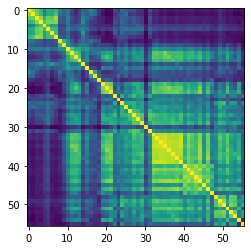

In [111]:
plt.imshow(mega_matrix[0]) #just checking

In [388]:
mega_matrix

[array([[1.        , 0.85242361, 0.77748815, ..., 0.09565375, 0.07663647,
         0.11253032],
        [0.85242361, 1.        , 0.79368848, ..., 0.06085067, 0.05535838,
         0.08030987],
        [0.77748815, 0.79368848, 1.        , ..., 0.10762053, 0.1124943 ,
         0.10043017],
        ...,
        [0.09565375, 0.06085067, 0.10762053, ..., 1.        , 0.44749092,
         0.58375258],
        [0.07663647, 0.05535838, 0.1124943 , ..., 0.44749092, 1.        ,
         0.14368279],
        [0.11253032, 0.08030987, 0.10043017, ..., 0.58375258, 0.14368279,
         1.        ]])]

In [305]:
regressor_indices = [
        np.tile(np.arange(8), 7),  # subjects
        np.repeat(np.arange(7), 8),  # ROIs
        #np.hstack((np.repeat(0, 8), np.repeat(1, 8*3), np.repeat(2, 8*3))),  # hierarchy
        #np.hstack((np.repeat(0, 8), np.repeat(1, 8), np.repeat(2, 8), np.repeat(3, 8),
        #           np.repeat(1, 8), np.repeat(2, 8), np.repeat(3, 8))), #streams
        
    ]

regressors = []
view = []
for indices in regressor_indices:
    base = np.zeros((56, 56))
    xx, yy = np.meshgrid(indices, indices)
    base[xx == yy] = 1
    
    view.append(base)

    regressors.append(get_lower_tri(1 - base, with_diagonal=False))


In [306]:
regressors[0].shape

(1540,)

IndexError: list index out of range

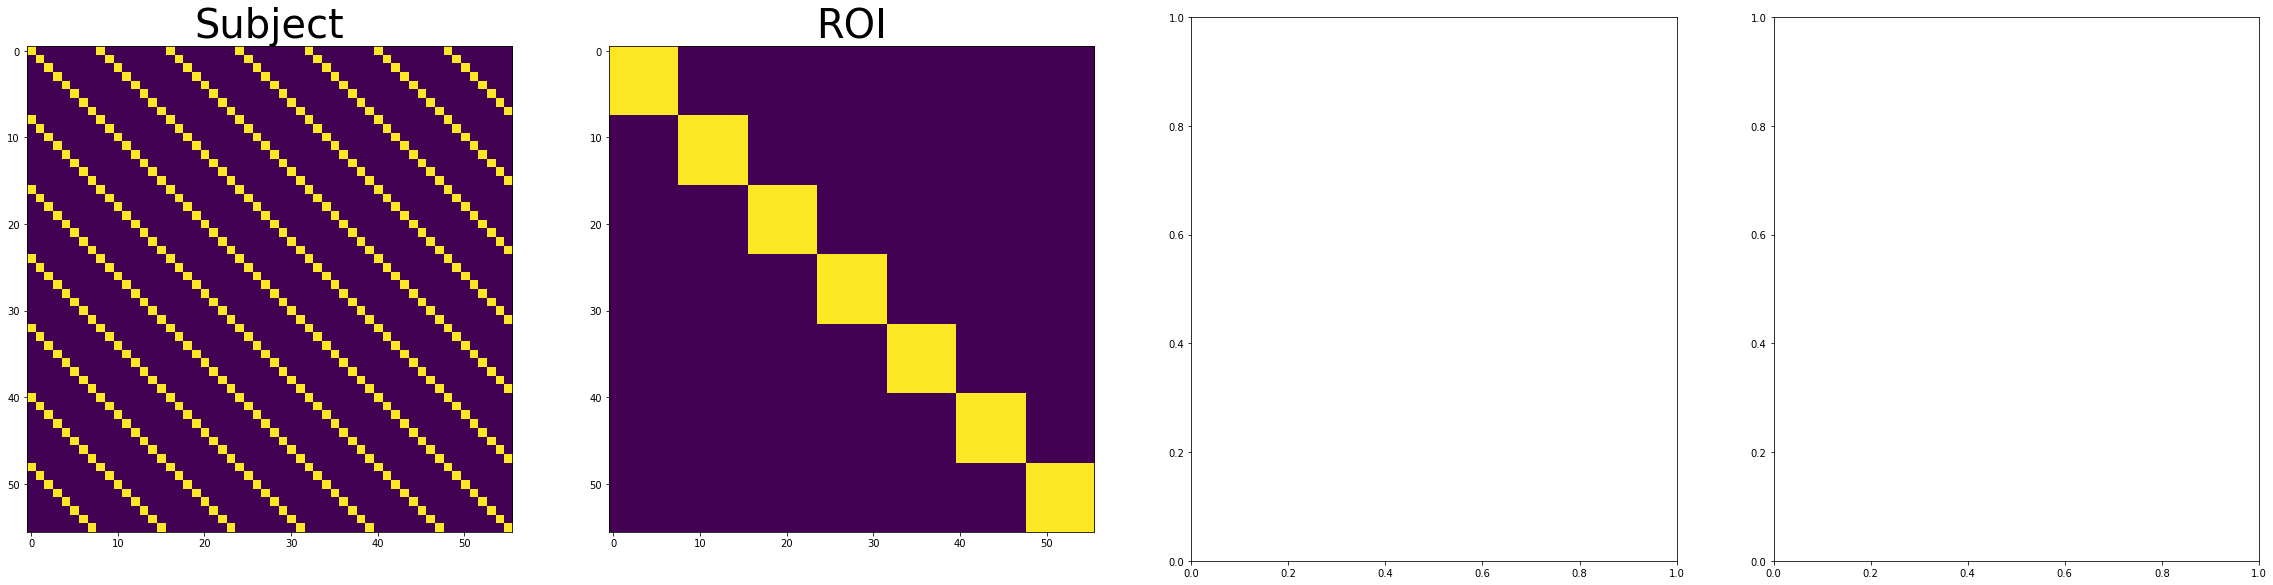

In [307]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4,figsize=(40,10))

ax1.imshow(view[0])
ax1.set_title('Subject', fontsize=40)
ax2.imshow(view[1])
ax2.set_title('ROI', fontsize=40)
ax3.imshow(view[2])
ax3.set_title('Hierarchy', fontsize=40)
ax4.imshow(view[3])
ax4.set_title('Stream', fontsize=40)


In [308]:
X = np.array([x.flatten() for x in regressors]).T

In [309]:
X.shape

(1540, 2)

In [310]:
mega_RDM = get_lower_tri(1 - mega_matrix[0], with_diagonal=False)

In [311]:
reg_rh = LinearRegression().fit(X, mega_RDM)

In [312]:
reg_rh.coef_

array([0.037806  , 0.24789891])

In [313]:
reg_rh.score(X,mega_RDM)

0.13773295219987858

In [314]:
X2 = sm.add_constant(X) #fit intercept

est = sm.OLS(mega_RDM, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.138
Model:                            OLS   Adj. R-squared:                  0.137
Method:                 Least Squares   F-statistic:                     122.8
Date:                Tue, 12 Jan 2021   Prob (F-statistic):           3.47e-50
Time:                        10:20:11   Log-Likelihood:                 256.28
No. Observations:                1540   AIC:                            -506.6
Df Residuals:                    1537   BIC:                            -490.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3332      0.022     14.891      0.0

In [125]:
##### mega mega matrix version

In [126]:
with open(local_data_dir + 'processed/mega_mega_matrix.data', 'rb') as filehandle:
    # read the data as binary data stream
    mega_mega_matrix = pickle.load(filehandle)

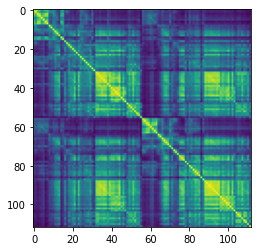

In [127]:
plt.imshow(mega_mega_matrix[0]) #just checking

In [323]:
regressor_indices = [
        np.hstack((np.repeat(1, 56), np.repeat(0, 56))), #hemisphere
        np.tile(np.tile(np.arange(8), 7),2),  # subjects
        np.tile(np.repeat(np.arange(7), 8),2),  # ROIs
        #np.tile(np.hstack((np.repeat(0, 8), np.repeat(1, 8*3), np.repeat(2, 8*3))),2),  # hierarchy
        #np.tile(np.hstack((np.repeat(0, 8), np.repeat(1, 8), np.repeat(2, 8), np.repeat(3, 8),
        #           np.repeat(1, 8), np.repeat(2, 8), np.repeat(3, 8))),2), #streams
        
    ]

regressors = []
view = []
for indices in regressor_indices:
    base = np.zeros((56*2, 56*2))
    xx, yy = np.meshgrid(indices, indices)
    base[xx == yy] = 1
    
    view.append(base)

    regressors.append(get_lower_tri(1 - base, with_diagonal=False))


Text(0.5, 1.0, 'ROI')

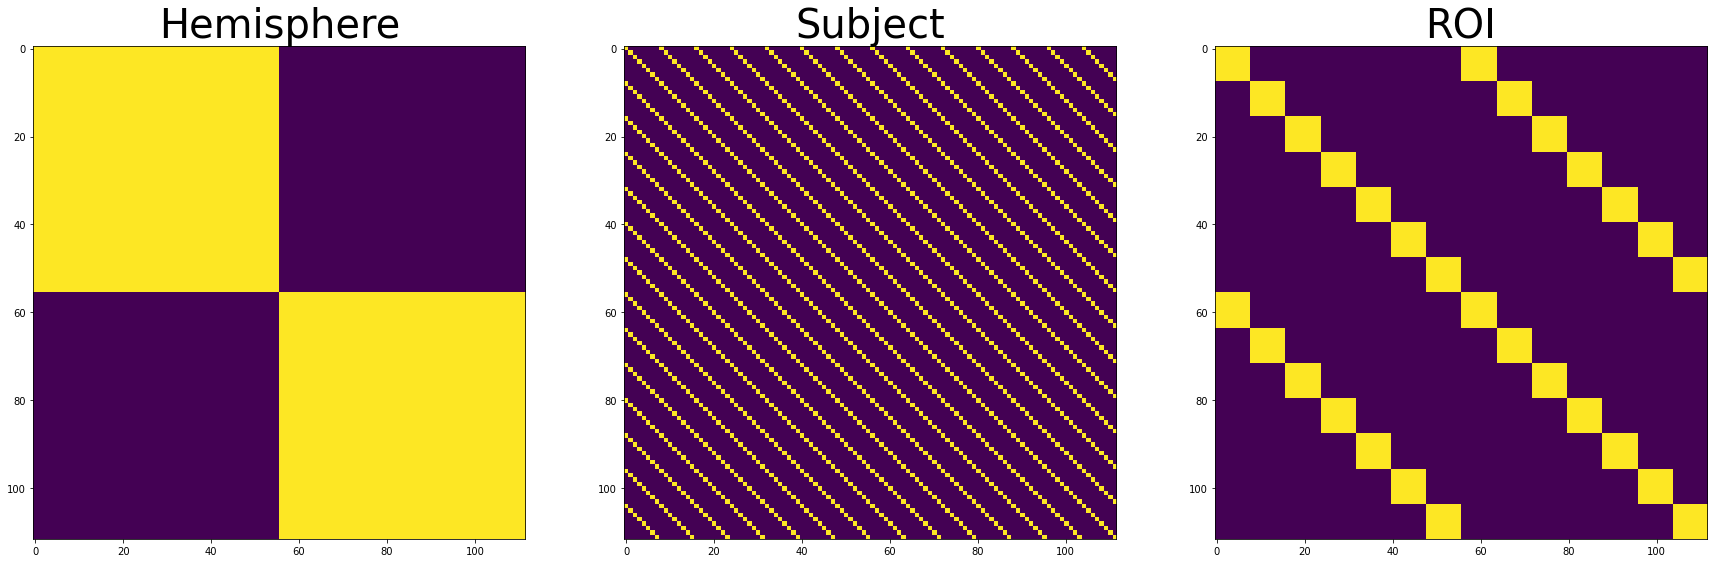

In [324]:
fig, (ax0, ax1, ax2) = plt.subplots(1, 3,figsize=(30,10))

ax0.imshow(view[0])
ax0.set_title('Hemisphere', fontsize=40)
ax1.imshow(view[1])
ax1.set_title('Subject', fontsize=40)
ax2.imshow(view[2])
ax2.set_title('ROI', fontsize=40)

In [325]:
mega_mega_RDM = get_lower_tri(1 - mega_mega_matrix[0], with_diagonal=False)

In [326]:
from sklearn.linear_model import LinearRegression
from sklearn import datasets, linear_model
import statsmodels.api as sm
from scipy import stats

X = np.array([x.flatten() for x in regressors]).T
y = mega_mega_RDM

In [327]:
reg = LinearRegression().fit(X, y)

In [328]:
reg.coef_

array([0.06361944, 0.03172663, 0.21078027])

In [329]:
reg.intercept_

0.38413229358685824

In [330]:
reg.score(X,y)

0.1369256553080691

In [331]:
X2 = sm.add_constant(X) #fit intercept

est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.137
Model:                            OLS   Adj. R-squared:                  0.137
Method:                 Least Squares   F-statistic:                     328.5
Date:                Tue, 12 Jan 2021   Prob (F-statistic):          5.41e-198
Time:                        10:20:54   Log-Likelihood:                 1308.7
No. Observations:                6216   AIC:                            -2609.
Df Residuals:                    6212   BIC:                            -2582.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3841      0.010     37.278      0.0